In [13]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

## Train

In [39]:
test  = pd.read_csv('../data/test.csv').set_index('ID')

In [40]:
data = pd.read_pickle('data.pkl')


In [41]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
#     'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
#     'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [42]:
# 0~32개월 : Train
# 33 개월 :  Validation
# 34 개월 :  Test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [43]:
del data
gc.collect();

In [44]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

In [45]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)


[16:54:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15036	validation_1-rmse:1.11622
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.09668	validation_1-rmse:1.07751
[2]	validation_0-rmse:1.05502	validation_1-rmse:1.04697
[3]	validation_0-rmse:1.01866	validation_1-rmse:1.02119
[4]	validation_0-rmse:0.98527	validation_1-rmse:0.99846
[5]	validation_0-rmse:0.95772	validation_1-rmse:0.98102
[6]	validation_0-rmse:0.93518	validation_1-rmse:0.96711
[7]	validation_0-rmse:0.91553	validation_1-rmse:0.95603
[8]	validation_0-rmse:0.89751	validation_1-rmse:0.94589
[9]	validation_0-rmse:0.88116	validation_1-rmse:0.93754
[10]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [14]:
rf = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [15]:
rf_pred = rf.predict(X_valid).clip(0,20)

In [16]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, rf_pred)))

validation rmse: 0.940858768572555


In [19]:
rf_test = rf.predict(X_test).clip(0, 20)

In [18]:
knn = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn.fit(X_train, Y_train)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [20]:
knn_pred = knn.predict(X_valid).clip(0,20)
knn_test = knn.predict(X_test).clip(0, 20)

In [21]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, knn_pred)))

validation rmse: 1.036


In [24]:
linear = LinearRegression(n_jobs=-1)
linear.fit(X_train, Y_train)

LinearRegression(n_jobs=-1)

In [25]:
linear_pred = linear.predict(X_valid).clip(0,20)
linear_test = linear.predict(X_test).clip(0, 20)

In [26]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, linear_pred)))

validation rmse: 0.9628517


## Predict

In [46]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [47]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, Y_pred)))

validation rmse: 0.90569586


In [27]:
first_level = pd.DataFrame(Y_pred, columns=['xgbm'])
first_level['random_forest'] = rf_pred
first_level['linear_regression'] = linear_pred
first_level['knn'] = knn_pred
first_level['label'] = Y_valid.values
first_level.head(20)

,xgbm,random_forest,linear_regression,knn,label
0,0.041903,0.075468,0.000000,0.222168,0.0
1,0.117601,0.221430,0.000000,0.111084,1.0
2,0.253358,0.070673,0.083597,0.333252,0.0
3,0.225505,0.221430,0.384206,0.111084,0.0
4,0.006981,0.022753,0.021832,0.000000,0.0
5,0.001057,0.022753,0.000000,0.000000,0.0
6,0.008484,0.022753,0.000000,0.000000,0.0
7,0.007735,0.022753,0.000000,0.000000,0.0
8,0.007735,0.022753,0.000000,0.000000,0.0
9,0.033169,0.075468,0.000000,0.000000,0.0


In [28]:
first_level_test = pd.DataFrame(Y_test, columns=['xgbm'])
first_level_test['random_forest'] = rf_test
first_level_test['linear_regression'] = linear_test
first_level_test['knn'] = knn_test
first_level_test.head()

,xgbm,random_forest,linear_regression,knn
0,0.729993,0.369144,0.466291,1.666992
1,0.595191,0.566893,0.373143,4.554688
2,1.266816,0.688148,1.137572,3.222656
3,0.542370,0.464499,0.298650,0.777832
4,3.817008,2.915311,0.390014,0.000000


In [29]:
meta_model = LinearRegression(n_jobs=-1)

In [30]:
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_valid)

LinearRegression(n_jobs=-1)

In [35]:
ensemble_pred = meta_model.predict(first_level).clip(0, 20)
final_predictions = meta_model.predict(first_level_test).clip(0, 20)

In [36]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

Train rmse: 0.9046096446222068


In [37]:
prediction_df = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": final_predictions
})
prediction_df.to_csv('submission/edaenemble_submission.csv', index=False)

## Submission

In [11]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission/xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('model/xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('model/xgb_test.pickle', 'wb'))

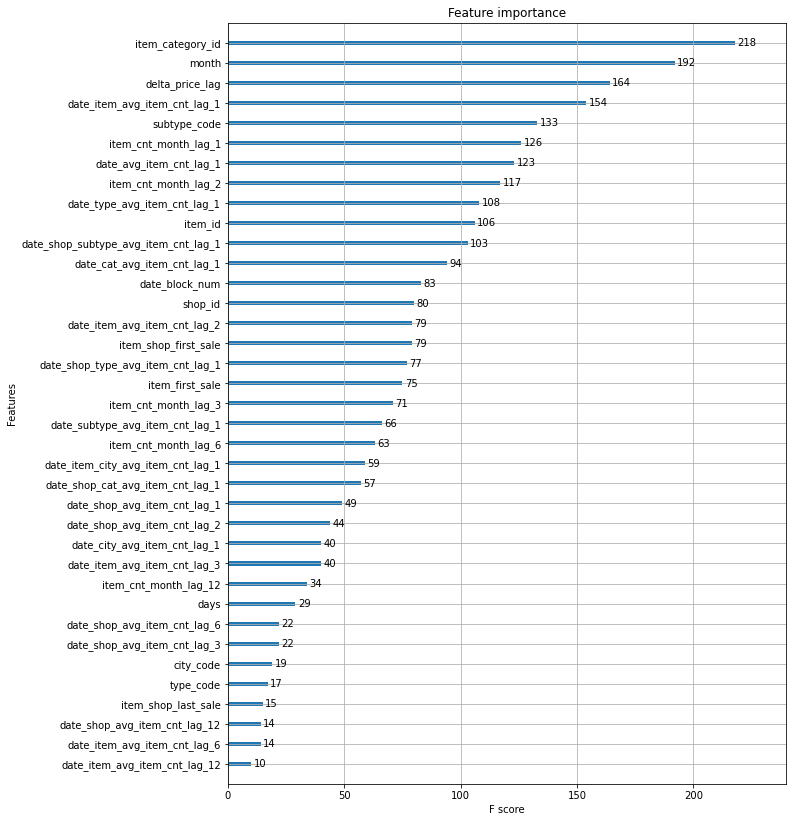

In [12]:
plot_features(model, (10,14))